In [5]:
!pip install nlp


In [6]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [7]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [8]:
dataset


{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [9]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [10]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [11]:
tweets, labels = get_tweet(train)

In [12]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=10000,  oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

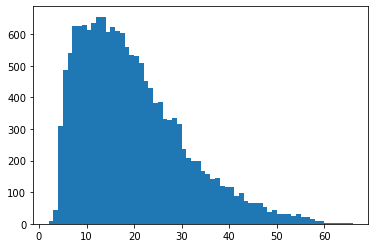

In [15]:
lengths = [ len(t.split(' '))  for t in tweets ]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [16]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded= pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [18]:
padded_train_seq= get_sequences(tokenizer, tweets)

In [19]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [20]:
classes=set(labels)
print(classes)

{'surprise', 'joy', 'love', 'sadness', 'fear', 'anger'}


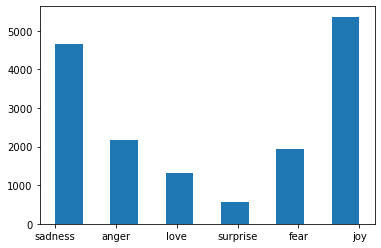

In [21]:
plt.hist(labels, bins=11)
plt.show()

In [22]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v  in class_to_index.items())

In [23]:
class_to_index

{'surprise': 0, 'joy': 1, 'love': 2, 'sadness': 3, 'fear': 4, 'anger': 5}

In [24]:
index_to_class

{0: 'surprise', 1: 'joy', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'anger'}

In [25]:
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels ])

In [26]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


In [27]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [29]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [30]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [31]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2) 
    ]
    
)

Epoch 1/20
500/500 [==============================] - 22s 34ms/step - loss: 1.3341 - accuracy: 0.4730 - val_loss: 0.8896 - val_accuracy: 0.6640
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.5863 - accuracy: 0.7857 - val_loss: 0.5682 - val_accuracy: 0.8045
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.3230 - accuracy: 0.8909 - val_loss: 0.4577 - val_accuracy: 0.8515
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2307 - accuracy: 0.9261 - val_loss: 0.5014 - val_accuracy: 0.8430
Epoch 5/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1734 - accuracy: 0.9448 - val_loss: 0.4746 - val_accuracy: 0.8665
Epoch 6/20
500/500 [==============================] - 21s 41ms/step - loss: 0.1415 - accuracy: 0.9553 - val_loss: 0.4765 - val_accuracy: 0.8700
Epoch 7/20
500/500 [==============================] - 20s 41ms/step - loss: 0.1073 - accuracy: 0.9661 - val_loss: 0.4373 - val_accuracy:

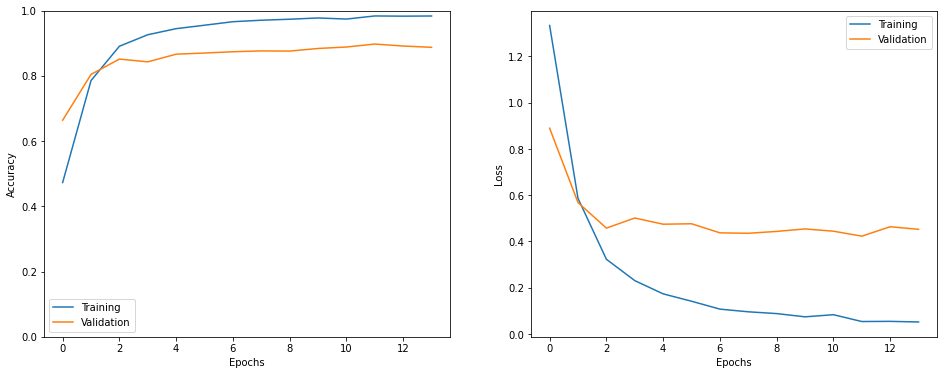

In [32]:
show_history(h)

In [33]:
test_tweets, test_labels= get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [50]:
x = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.4620 - accuracy: 0.8880
